# mCNV Analysis

In [1]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess

import cdpybio as cpb
from ipyparallel import Client
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels as sms
import statsmodels.api as sm
import statsmodels.formula.api
import statsmodels.formula.api as smf
import tabix
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

dy_name = 'mcnv_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
gene_info['ensembl_id'] = [x.split('.')[0] for x in gene_info.index]

genes = pbt.BedTool(cpy.gencode_gene_bed)

dy = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01')
fn = os.path.join(dy, 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)

In [3]:
dy = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01')
fn = os.path.join(dy, 'gene_variant_pairs.tsv')
gene_variant = pd.read_table(fn, index_col=0)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'gs_combined_info.pickle')
gs_info = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'private_output', 'cnv_processing', 'mcnvs.tsv')
mcnvs = pd.read_table(fn, index_col=0)

In [5]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'variant_regions.bed')
variant_regions = pbt.BedTool(fn)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
eqtl_tpm = pd.read_table(fn, index_col=0)
eqtl_tpm = eqtl_tpm[(gene_info.ix[eqtl_tpm.index, 'chrom'] != 'chrX') & 
                    (gene_info.ix[eqtl_tpm.index, 'chrom'] != 'chrY') &
                    (gene_info.ix[eqtl_tpm.index, 'chrom'] != 'chrM')]

## mCNV eQTLs

I want to test for an association between mCNVs and gene expression. I'm going to start
by using unrelated individuals. There are genetically unrelated people in families (for
instance the parents in a trio are unrelated) but for now I'll just take one person from
each family.

### mCNV samples

In [6]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'unrelateds.tsv')
mcnv_samples = pd.read_table(fn, index_col=0)

In [7]:
mcnv_samples_by_wgs = mcnv_samples.copy(deep=True)
mcnv_samples_by_wgs['rna_id'] = mcnv_samples_by_wgs.index
mcnv_samples_by_wgs.index = mcnv_samples_by_wgs.wgs_id
mcnv_samples_by_wgs = mcnv_samples_by_wgs.merge(subject_meta, left_on='subject_id', right_index=True)

### mCNV filtering

I'll filter the mCNVs based on the samples I'm using here.

In [8]:
mcnvs_f = mcnvs[mcnv_samples.wgs_id]
b = mcnvs_f.apply(lambda x: x.value_counts().max() < mcnvs_f.shape[1] - np.floor(mcnvs_f.shape[1] * 0.05), axis=1)
mcnvs_f = mcnvs_f[b]

In [9]:
t = gs_info.ix[mcnvs_f.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
mcnvs_bt = pbt.BedTool(s, from_string=True)
mcnvs_bt = mcnvs_bt.sort()

In [10]:
# Let's find out which mCNVs overlap the variant regions for the genes.
res = mcnvs_bt.intersect(variant_regions, sorted=True, wo=True)
df = res.to_dataframe()
df['gene'] = df.thickEnd.apply(lambda x: x.split('_')[0])
# I'll make a mapping from gene to mCNV.
gene_to_mcnv = pd.Series(df.name.values, index=df.gene)

In [11]:
eqtl_tpm_f = eqtl_tpm[mcnv_samples.wgs_id]
eqtl_tpm_f = cpb.general.transform_standard_normal(eqtl_tpm_f)

In [12]:
mcnvs_f.to_csv(os.path.join(private_outdir, 'filtered_mcnvs.tsv'), sep='\t')

### Regression

In [13]:
def mcnv_data(gene):
    cnvs = gene_to_mcnv[gene]
    if type(cnvs) is pd.core.series.Series:
        cnvs = list(cnvs)
    else:
        cnvs = [cnvs]
    data = mcnvs_f.ix[cnvs].T
    data['exp'] = eqtl_tpm_f.ix[gene, data.index].values
    data['sex'] = (mcnv_samples_by_wgs.ix[data.index, 'sex'] == 'M').values
    return data

def mcnv_regression(gene):
    cnvs = gene_to_mcnv[gene]
    if type(cnvs) is pd.core.series.Series:
        cnvs = list(cnvs)
    else:
        cnvs = [cnvs]
    data = mcnvs_f.ix[cnvs].T
    data['exp'] = eqtl_tpm_f.ix[gene, data.index].values
    data['sex'] = (mcnv_samples_by_wgs.ix[data.index, 'sex'] == 'M').values
    data = mcnv_data(gene)
    results = {}
    for cnv in cnvs:
        results[cnv] = statsmodels.formula.api.ols('exp ~ {} + sex'.format(cnv), data=data).fit()
    return results

In [14]:
se = gene_to_mcnv.ix[set(gene_to_mcnv.index) & set(eqtl_tpm_f.index)]
print('{:,} total tests'.format(se.shape[0]))
print('{:,} distinct genes'.format(len(set(se.index))))
print('{:,} distinct mCNVs'.format(len(set(se.values))))

2,952 total tests
1,493 distinct genes
152 distinct mCNVs


In [15]:
fn = os.path.join(outdir, 'results.pickle')
if not os.path.exists(fn):
    ind = list(set(gene_to_mcnv.index) & set(eqtl_tpm_f.index))
    gene_results = []
    for g in ind:
        gene_results.append(mcnv_regression(g))
    with open(fn , 'w') as f:
        cPickle.dump(gene_results, f)
else:
    gene_results = cPickle.load(open(fn))

In [16]:
fn = os.path.join(outdir, 'reg_results.tsv')
if not os.path.exists(fn):
    g = []
    c = []
    p = []
    b = []
    for i,d in enumerate(gene_results):
        for k in d.keys():
            g.append(ind[i])
            c.append(k)
            p.append(d[k].pvalues[k])
            b.append(d[k].params[k])
    reg_results = pd.DataFrame({'gene':g, 'cnv':c, 'pvalue':p, 'beta':b})
    r = sms.sandbox.stats.multicomp.multipletests(reg_results.pvalue, method='fdr_bh')
    reg_results['bh_pvalue'] = r[1]
    reg_results['bh_sig'] = r[0]
    reg_results = reg_results.merge(gs_info, left_on='cnv', right_index=True).drop(['name'], axis=1)
    reg_results = reg_results.merge(gene_info, left_on='gene', right_index=True, suffixes=['', '_gene'])
    reg_results['overlap_gene'] = (((reg_results.start > reg_results.start_gene) & 
                                    (reg_results.start < reg_results.end_gene)) | 
                                   ((reg_results.end > reg_results.start_gene) & 
                                    (reg_results.end < reg_results.end_gene)))
    a = reg_results.end - reg_results.start_gene
    b = reg_results.start - reg_results.end_gene
    t = pd.DataFrame([a,b]).T
    ta = t.abs()
    tv = t[ta.apply(lambda x: x == x.min(), axis=1)]
    tv = tv.fillna(0).sum(axis=1)
    reg_results['dist_to_gene'] = tv
    reg_results.ix[reg_results.overlap_gene, 'dist_to_gene'] = 0
    reg_results.to_csv(fn, sep='\t')
else:
    reg_results = pd.read_table(fn, index_col=0)
sig = reg_results[reg_results.bh_sig]
sig.sort_values(by='pvalue', inplace=True)

In [17]:
a = len(set(sig.gene))
b = len(set(sig.gene) - set(sig.ix[sig.overlap_gene, 'gene']))
print('{} mCNV eGenes, {} of which are intergenic.'.format(a, b))

89 mCNV eGenes, 67 of which are intergenic.


In [18]:
n = len(set(gene_variant.ix[gene_variant.variant_type == 'cnv', 'gene_id']) | 
        set(sig.gene))
print('{} genes have a significant CNV association considering both '
      'biallelic and mCNVs.'.format(n))

469 genes have a significant CNV association considering both biallelic and mCNVs.


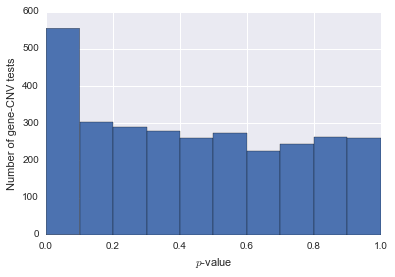

In [19]:
reg_results.pvalue.hist()
plt.ylabel('Number of gene-CNV tests')
plt.xlabel('$p$-value');

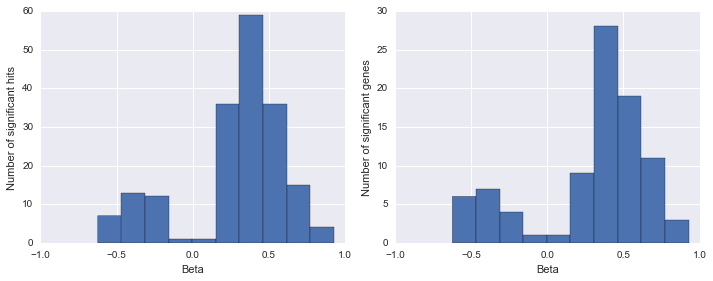

In [20]:
fig,axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]
sig.beta.hist(ax=ax)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('Number of significant hits')
ax.set_xlabel('Beta');

ax = axs[1]
sig.drop_duplicates(subset=['gene']).beta.hist(ax=axs[1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('Number of significant genes')
ax.set_xlabel('Beta');
plt.tight_layout()

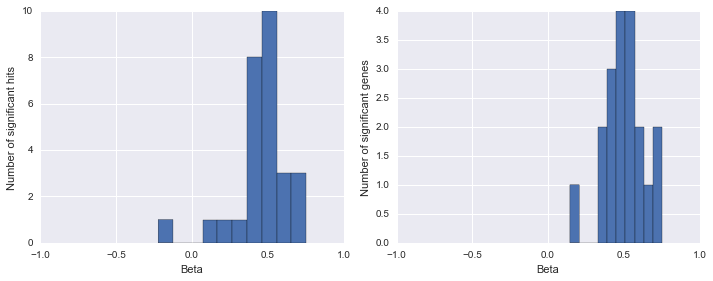

In [21]:
fig,axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]
sig[sig.overlap_gene].beta.hist(ax=ax)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('Number of significant hits')
ax.set_xlabel('Beta');

ax = axs[1]
t = sig.drop_duplicates(subset=['gene'])
t[t.overlap_gene].beta.hist(ax=axs[1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('Number of significant genes')
ax.set_xlabel('Beta');
plt.tight_layout()

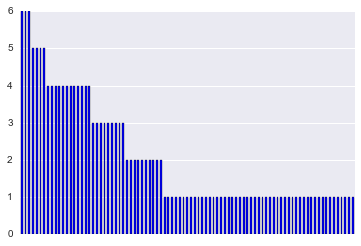

In [22]:
sig.gene.value_counts().plot(kind='bar')
plt.xticks([]);

In [23]:
len(set(sig.gene))

89

In [24]:
len(set(sig.ix[sig.overlap_gene, 'gene']))

22

In [25]:
sig.overlap_gene.value_counts()

False    156
True      28
Name: overlap_gene, dtype: int64

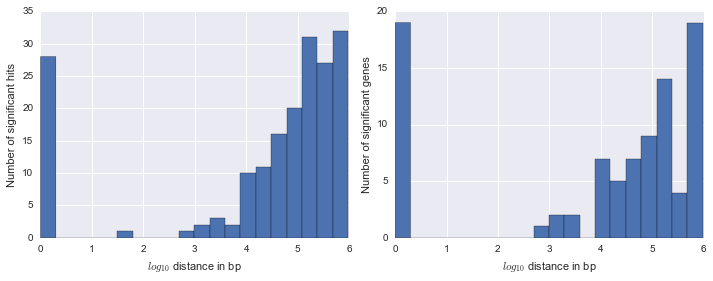

In [26]:
fig,axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]
(np.log10(sig.dist_to_gene.abs() + 1)).hist(ax=ax, bins=20)
ax.set_ylabel('Number of significant hits')
ax.set_xlabel('$log_{10}$ distance in bp');

ax = axs[1]
(np.log10(sig.drop_duplicates(subset=['gene']).dist_to_gene.abs() + 1)).hist(ax=axs[1], bins=20)
ax.set_ylabel('Number of significant genes')
ax.set_xlabel('$log_{10}$ distance in bp');
plt.tight_layout()

In [27]:
def plot_results(gene):
    data = mcnv_data(gene)
    s = sig[sig.gene == gene]
    for c in s.cnv:
        sns.lmplot(x=c, y='exp', data=data, x_jitter=0.2)
        plt.ylabel(gene_info.ix[gene, 'gene_name'])

In [109]:
sig.shape

(184, 54)

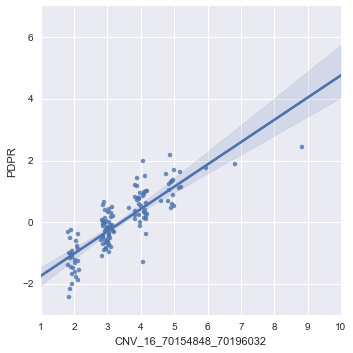

In [29]:
plot_results(sig.gene.drop_duplicates().values[0])

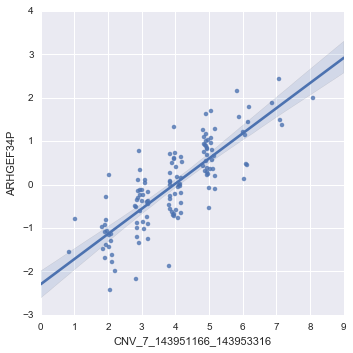

In [30]:
plot_results(sig.gene.drop_duplicates().values[1])

In [31]:
sig_cnvs = set(sig.cnv)
not_sig_cnvs = set(reg_results.cnv) - sig_cnvs
a = gs_info.ix[sig_cnvs, 'nearest_tss_dist'].abs()
a = a[a != 0]
b = gs_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
b = b[b != 0]
s,p = stats.mannwhitneyu(a, b)
print(p)

0.0616635595758


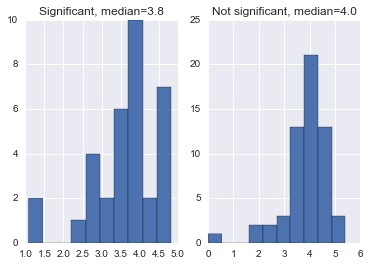

In [32]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(a.abs()).hist(ax=ax)
ax.set_title('Significant, median={:.1f}'.format(np.log10(a.abs()).median()))
ax = axs[1]
ax.set_title('Not significant, median={:.1f}'.format(np.log10(b.abs()).median()))
np.log10(b.abs()).hist(ax=ax);

In [33]:
sig_cnvs = set(sig.cnv) - set(sig.ix[sig.overlap_gene, 'cnv'])
not_sig_cnvs = set(reg_results.cnv) - sig_cnvs
a = gs_info.ix[sig_cnvs, 'nearest_tss_dist'].abs()
a = a[a != 0]
b = gs_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
b = b[b != 0]
s,p = stats.mannwhitneyu(a, b)
print(p)

0.356201652606


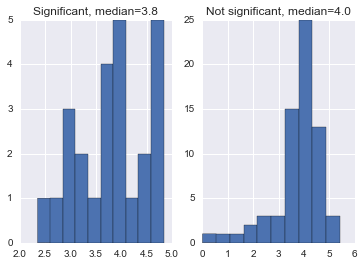

In [34]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(a.abs()).hist(ax=ax)
ax.set_title('Significant, median={:.1f}'.format(np.log10(a.abs()).median()))
ax = axs[1]
ax.set_title('Not significant, median={:.1f}'.format(np.log10(b.abs()).median()))
np.log10(b.abs()).hist(ax=ax);

## Number of QTLs per mCNV

Some mCNVs seem to have several QTLs. In most cases this seems to be because the mCNV
overlaps several genes. Sometimes multiple adjacent mCNVs will all be associated with
the same genes meaning these mCNVs should probably be merged into one large CNV.

In [35]:
sig.sort_values(by='overlap_gene', ascending=False).drop_duplicates(subset=['gene']).overlap_gene.value_counts()

False    67
True     22
Name: overlap_gene, dtype: int64

In [36]:
vc = sig.cnv.value_counts()
vc.head(15)

CNV_17_44566797_44580424     11
CNV_17_44336433_44367851     11
CNV_17_44311202_44328032     10
CNV_7_143951166_143953316     7
CNV_1_16885240_16950375       7
CNV_17_43650217_43655844      7
CNV_10_46945989_47151257      6
CNV_1_17038864_17050729       6
CNV_17_43655545_43662029      6
CNV_8_12395839_12427801       5
CNV_8_12427702_12432588       5
CNV_8_12432914_12454865       5
CNV_8_11979660_12009126       5
CNV_1_16951816_16969312       5
CNV_16_2697066_2700519        4
Name: cnv, dtype: int64

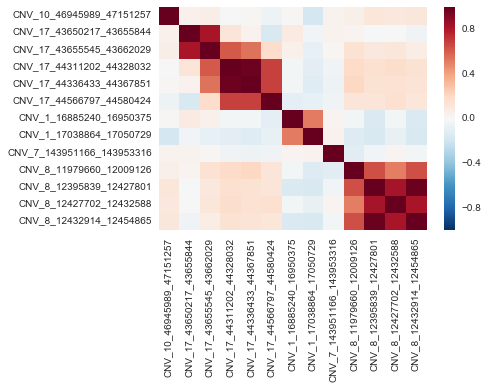

In [37]:
c = mcnvs_f.ix[sorted(vc.head(13).index)].T.corr(method='spearman')
sns.heatmap(c)

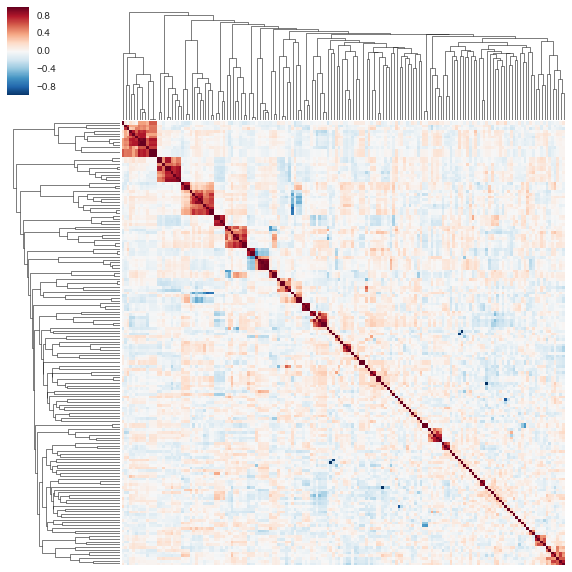

In [38]:
mcnvs_f_corr = mcnvs_f.T.corr(method='spearman')
sns.clustermap(mcnvs_f_corr, xticklabels=[], yticklabels=[]);

In [116]:
data[data.CNV_7_143951166_143953316 == 8]

,CNV_7_143951166_143953316,exp,sex,gene
4fc00735-6005-4e26-a5d9-3008c62aa632,8,2.000424,True,ARHGEF34P
4fc00735-6005-4e26-a5d9-3008c62aa632,8,2.166107,True,OR2A7
4fc00735-6005-4e26-a5d9-3008c62aa632,8,1.335178,True,ARHGEF5
4fc00735-6005-4e26-a5d9-3008c62aa632,8,1.775850,True,OR2A1-AS1
4fc00735-6005-4e26-a5d9-3008c62aa632,8,1.876359,True,CTAGE15
4fc00735-6005-4e26-a5d9-3008c62aa632,8,2.000424,True,AC004889.1
4fc00735-6005-4e26-a5d9-3008c62aa632,8,-0.018991,True,RP4-545C24.1


In [115]:
data.ix['985362a3-e536-4368-8996-2bc2db0d8fd5']

,CNV_7_143951166_143953316,exp,sex,gene
985362a3-e536-4368-8996-2bc2db0d8fd5,5,0.537519,False,ARHGEF34P
985362a3-e536-4368-8996-2bc2db0d8fd5,5,-0.095091,False,OR2A7
985362a3-e536-4368-8996-2bc2db0d8fd5,5,-0.389414,False,ARHGEF5
985362a3-e536-4368-8996-2bc2db0d8fd5,5,0.825494,False,OR2A1-AS1
985362a3-e536-4368-8996-2bc2db0d8fd5,5,-0.288809,False,CTAGE15
985362a3-e536-4368-8996-2bc2db0d8fd5,5,0.308666,False,AC004889.1
985362a3-e536-4368-8996-2bc2db0d8fd5,5,-0.269066,False,RP4-545C24.1


In [113]:
data.head()

,CNV_7_143951166_143953316,exp,sex,gene
34c79720-7710-4f86-b1fc-ef6565ab8459,2,-1.434200,False,ARHGEF34P
985362a3-e536-4368-8996-2bc2db0d8fd5,5,0.537519,False,ARHGEF34P
4d04f714-2d68-4663-8c69-ed16606670b0,3,-0.494133,True,ARHGEF34P
6354fc10-d70a-4453-b414-0d023f8de3b5,2,-1.062786,True,ARHGEF34P
00ac22e8-826e-49df-8216-04571b00ac21,2,-0.937532,False,ARHGEF34P


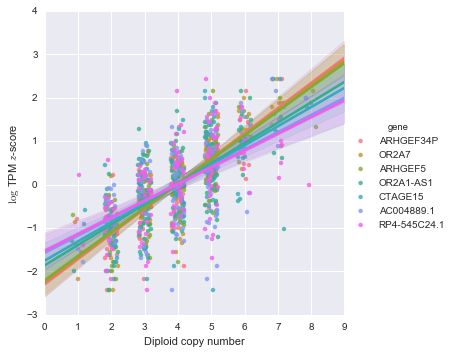

In [112]:
tt = sig[sig.cnv == 'CNV_7_143951166_143953316']

data = []
for gene in tt.gene:
    d = mcnv_data(gene)
    d['gene'] = gene_info.ix[gene, 'gene_name']
    data.append(d)
data = pd.concat(data)

data.to_csv(os.path.join(outdir, 'CNV_7_143951166_143953316_data.tsv'), sep='\t')

sns.lmplot(x='CNV_7_143951166_143953316', y='exp', data=data, hue='gene', x_jitter=0.2)
plt.ylabel('$\log$ TPM $z$-score')
plt.xlabel('Diploid copy number')
plt.savefig(os.path.join(outdir, 'CNV_7_143951166_143953316_example.pdf'))

## Intergenic

I want to find QTLs where it appears that the CNV does not overlap the gene. 
At first, this looks true for many of the mCNV eQTLs. While I've already merged CNVs,
I think that in some cases they need to be merged more. This should be apparent for genes
that are associated with multiple mCNVs.

I'll explore this a bit here.

In [91]:
vc = sig.gene.value_counts()
print('{} of {} mCNV eGenes are associated with more than one mCNV'.format(vc[vc > 1].shape[0], vc.shape[0]))
vc = vc[vc > 1]

38 of 89 mCNV eGenes are associated with more than one mCNV


In [92]:
overlap = []
for gene in vc.index:
    t = sig[sig.gene == gene]
    assert len(set(t.chrom)) == 1
    start = gs_info.ix[t.cnv, 'start'].min()
    end = gs_info.ix[t.cnv, 'end'].max()
    overlap.append(not (gene_info.ix[gene, 'start'] > end or gene_info.ix[gene, 'end'] < start))
overlap = pd.Series(overlap, index=vc.index)
print('{} of these {} overlap the combined mCNV.'.format(overlap.sum(), vc.shape[0]))

22 of these 38 overlap the combined mCNV.


In [93]:
t = sig[sig.gene.apply(lambda x: x not in overlap.index)]
se = t.overlap_gene
se.index = t.gene
overlap = pd.concat([overlap, se])

In [100]:
print('{} of {} overlap the gene after combining mCNVs.'.format(overlap.value_counts()[True], overlap.shape[0]))

33 of 89 overlap the gene after combining mCNVs.


In [101]:
t = sig[sig.gene.apply(lambda x: x in overlap[overlap == False].index)]

In [139]:
t.sort_values(by=['dist_to_gene'])[['gene_name']].tail(10)

,gene_name
855,LRRC37A4P
853,LRRC37A4P
1011,PMS2
2488,PLEKHM1
2486,PLEKHM1
2723,MTMR9
1979,CCZ1
2566,RP11-798G7.6
856,LRRC37A4P
2531,RP11-798G7.5


In [138]:
t.sort_values(by=['dist_to_gene'])[['gene_name']].head(10)

,gene_name
2521,LRRC37A2
2523,LRRC37A2
628,RP11-561C5.4
2444,BMS1P10
2853,NSFP1
2855,NSFP1
1165,RP11-15J10.1
1048,CBWD7
2178,FAM215B
1151,NSF


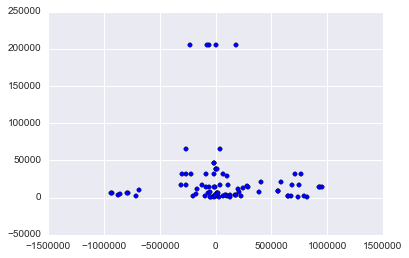

In [108]:
plt.scatter(t.dist_to_gene, t.length)

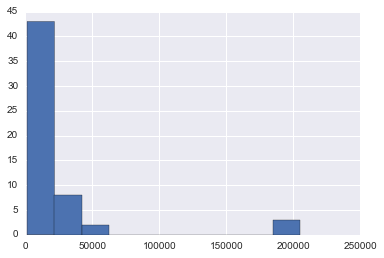

In [126]:
t.drop_duplicates('gene').length.hist()

In [122]:
(t.drop_duplicates('gene').dist_to_gene > 10000).value_counts()

False    29
True     27
Name: dist_to_gene, dtype: int64

In [117]:
(t.dist_to_gene > 10000).value_counts()

True     43
False    43
Name: dist_to_gene, dtype: int64

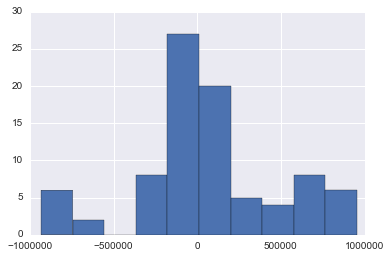

In [105]:
t.dist_to_gene.hist()

In [95]:
sig_intergenic_cnvs = set(sig.cnv) - set(sig.ix[sig.overlap_gene, 'cnv'])
not_sig_cnvs = set(reg_results.cnv) - set(sig.cnv)

In [96]:
len(sig_intergenic_cnvs)

36

In [127]:
len(not_sig_cnvs)

89

In [49]:
odds = []
pvalues = []
for c in roadmap_overlap.columns:
    vc = (roadmap_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    if True not in vc.index:
        sig_overlap = 0
    else:
        sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (roadmap_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
roadmap_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=roadmap_overlap.columns)
colors = pd.DataFrame(zip(list(set([x.split('_')[-1] for x in roadmap_res.index])), 
                          cpb.analysis.tableau20[::2]), columns=['mark', 'color'])
roadmap_res['mark'] = [x.split('_')[-1] for x in roadmap_res.index]
roadmap_res['ind'] = roadmap_res.index
roadmap_res = roadmap_res.merge(colors)
roadmap_res.index = roadmap_res.ind

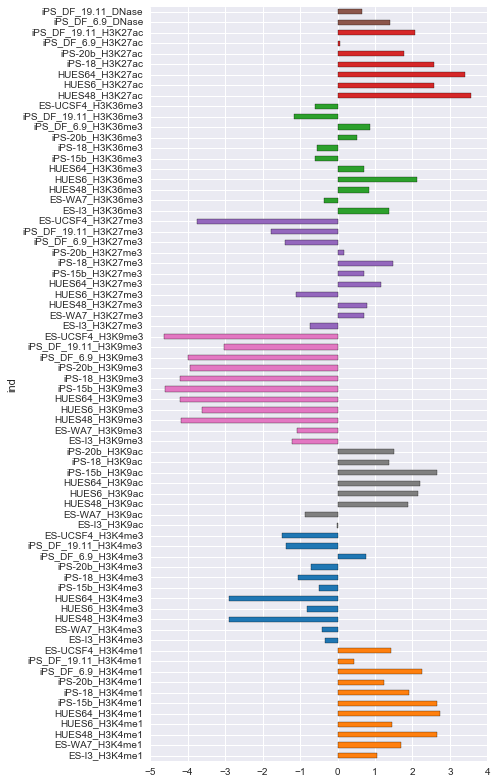

In [71]:
plt.figure(figsize=(7, 11))
(np.log2(roadmap_res.odds)).plot(kind='barh', color=roadmap_res.color)
plt.xlabel('')
plt.tight_layout()

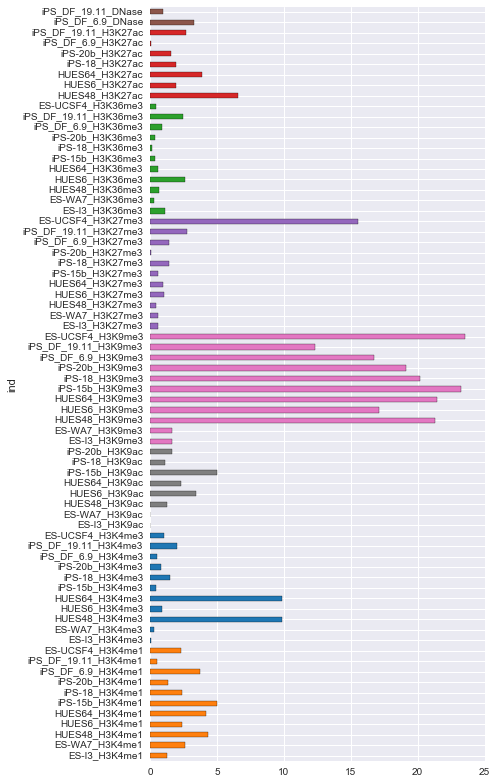

In [51]:
plt.figure(figsize=(7, 11))
(-np.log10(roadmap_res.pvalue)).plot(kind='barh', color=roadmap_res.color)
plt.tight_layout()

In [52]:
odds = []
pvalues = []
for c in encode_dnase_overlap.columns:
    vc = (encode_dnase_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (encode_dnase_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
encode_dnase_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=encode_dnase_overlap.columns)

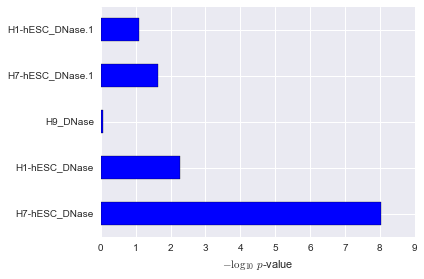

In [73]:
(-np.log10(encode_dnase_res.pvalue)).plot(kind='barh')
plt.xlabel('$-\log_{10}$ $p$-value')
plt.tight_layout()

In [54]:
odds = []
pvalues = []
for c in encode_chip_overlap.columns:
    vc = (encode_chip_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    if True not in vc.index:
        sig_overlap = 0
    else:
        sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (encode_chip_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    if True not in vc.index:
        not_sig_overlap = 0
    else:
        not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
encode_chip_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=encode_chip_overlap.columns)
encode_chip_res.sort_values(by='pvalue', inplace=True, ascending=False)

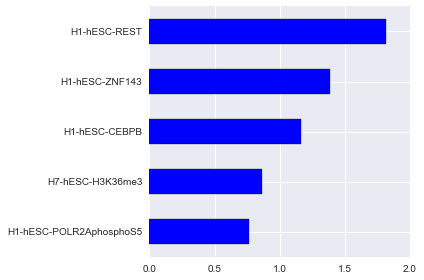

In [55]:
(-np.log10(encode_chip_res.pvalue.tail())).plot(kind='barh')
plt.tight_layout()

In [56]:
promoters = pbt.BedTool('/publicdata/gencode_v19_20151104/promoters_by_gene.bed')
df = promoters.to_dataframe()
df['gene'] = df.name.apply(lambda x: x.split('_')[0])
df['region'] = df.name.apply(lambda x: x.split('_')[2])
df.index = df.region
gb = df.groupby('gene')
gene_to_promoters = gb.groups

In [57]:
def get_hic_interactions(cnv, gene):
    # CNV location
    chrom,start,end = gs_info.ix[cnv, ['chrom', 'start', 'end']].values
    r = '{}:{}-{}'.format(chrom, start, end)
    fn = ('/projects/CARDIPS/pipeline/Hi-C/7_indv_HiC/contact_matrices/'
          'merged/normalized/iPSC/iPSC.5Kb.nor.{}.bed.gz'.format(chrom))
    t = tabix.open(fn)
    # Get lines for CNV.
    lines = []
    res = t.querys(r)
    while True:
        try:
            lines.append(res.next())
        except StopIteration:
            break
    # Get promoter regions.
    ps = [cpb.general.parse_region(x) for x in gene_to_promoters[gene]]
    # Get indices of columns for promoter regions.
    cols = []
    for x in ps:
        cols += range(int(x[1]) / 5000, int(x[2]) / 5000 + 1)
    cols = sorted(list(set(cols)))
    vals = []
    # Get values for promoter regions.
    for line in lines:
        vals.append([float(line[x + 3]) for x in cols])
    df = pd.DataFrame(vals)
    df.columns = np.array(cols) * 5000
    df.index = np.arange((start / 5000) * 5000, (end / 5000 + 1) * 5000, 5000)
    # Reflect over promoter regions and get interactions on other side.
    cnv_middle = int(start + (end - start) / 2.)
    promoter_middle = int(df.columns[0] + (df.columns[-1] - df.columns[0]) / 2.)
    null_start = int(2 * promoter_middle - cnv_middle - (end - start) / 2.)
    null_end = int(2 * promoter_middle - cnv_middle + (end - start) / 2.)
    if null_start < 0 or null_end < 0:
        return None, None
    else:
        # Get lines for CNV.
        r = '{}:{}-{}'.format(chrom, null_start, null_end)
        lines = []
        res = t.querys(r)
        while True:
            try:
                lines.append(res.next())
            except StopIteration:
                break
        vals = []
        # Get values for promoter regions.
        for line in lines:
            vals.append([float(line[x + 3]) for x in cols])
        null_df = pd.DataFrame(vals)
        null_df.columns = np.array(cols) * 5000
        null_df.index = np.arange((null_start / 5000) * 5000, (null_end / 5000 + 1) * 5000, 5000)
        return df, null_df

In [58]:
t = sig[sig.cnv.apply(lambda x: x in sig_intergenic_cnvs)]

In [59]:
real = []
null = []
dist = []
ind = []
for i in t.index:
    df, null_df = get_hic_interactions(t.ix[i, 'cnv'], t.ix[i, 'gene'])
    if df is not None:
        real.append(df.max().max())
        null.append(null_df.max().max())
        dist.append(abs(np.mean(df.columns) - np.mean(df.index)))
        ind.append(i)
real = pd.Series(real)
null = pd.Series(null)

In [60]:
hic = pd.DataFrame({'real':real.values, 'null':null.values, 'dist':dist}, index=ind)

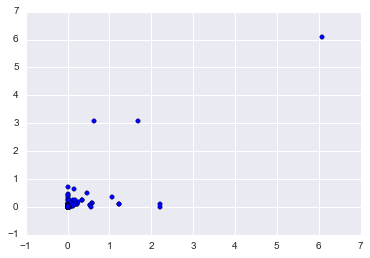

In [61]:
plt.scatter(hic.null * 10000, hic.real * 10000)

In [62]:
hic[hic.real * 10000 > 3]

,dist,null,real
2335,23333.333333,0.000169,0.000309
2337,28333.333333,0.000064,0.000309
1951,2500.000000,0.000609,0.000609


In [63]:
plot_results(t.ix[5764, 'gene'])

KeyError: 5764

In [ ]:
tdf = hic[hic.null == 0]

In [ ]:
tdf.sort_values(by='real', ascending=False, inplace=True)

In [ ]:
tdf.head()

In [ ]:
plot_results(t.ix[4537, 'gene'])